# Footprint

In [1]:
#librerias
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import modulo_conn_sql as mcq

In [2]:
#Query BD SQL-Server Cemex
def querySQL(query, parametros):
    #Conectar con base sql y ejecutar consulta
    cursor = conectarSQL()
    try:
        cursor.execute(query, parametros)
        #obtener nombre de columnas
        names = [ x[0] for x in cursor.description]
        
        #Reunir todos los resultado en rows
        rows = cursor.fetchall()
        resultadoSQL = []
            
        #Hacer un array con los resultados
        while rows:
            resultadoSQL.append(rows)
            if cursor.nextset():
                rows = cursor.fetchall()
            else:
                rows = None
                
        #Redimensionar el array para que quede en dos dimensiones
        resultadoSQL = np.array(resultadoSQL)
        resultadoSQL = np.reshape(resultadoSQL, (resultadoSQL.shape[1], resultadoSQL.shape[2]) )
    finally:
            if cursor is not None:
                cursor.close()
    return pd.DataFrame(resultadoSQL, columns = names)

#SQL Methods to get operation data
def conectarSQL():
    conn = mcq.ConexionSQL()
    cursor = conn.getCursor()
    return cursor

In [3]:
#dataset de codigos de obra con latitud, longitud y poligono geografico
obras_poligono = querySQL( "{CALL SCAC_AT15_UbicacionObras_poligonos}" , () )

In [23]:
obras_poligono

,Obra,latitud,longitud,Zona Comercial
0,66445414,4.44793622222222,-75.1764858888889,Ibague ...
1,66705451,18.557685,-69.701232,Dominicana ...
2,66390086,4.7563605,-74.147024,norte-occidente ...
3,66452153,10.4384396590909,-75.5247114772727,Cartagena ...
4,66464796,4.50596480530793,-74.10108389196817,bogota-sur ...
...,...,...,...,...
14696,66481333,4.69285544444444,-74.0648208333333,bogota-norte ...
14697,66835352,9.998141,-84.119764,Puente Piedra ...
14698,66538485,9.19475687589238,-79.6166631608791,Juan Diaz ...
14699,66171428,11.0057628333333,-74.2452311666667,Santa Marta ...


In [4]:
#dataset 2017 y 2018
pais='Colombia'
years = [2017, 2018]

for i,var in enumerate(years):
    if i == 0:
        dataset = querySQL( "{CALL SCAC_AP10_dataset_servicios_2 (?,?)}" , (pais, var) )
        dataset = dataset.fillna(value=np.nan)
        dataset['year_month'] = dataset.FechaEntrega.dt.to_period('M')
    else:
        temp = querySQL( "{CALL SCAC_AP10_dataset_servicios_2 (?,?)}" , (pais, var) )
        temp = temp.fillna(value=np.nan)
        temp['year_month'] = temp.FechaEntrega.dt.to_period('M')
        
        dataset = pd.concat([dataset, temp ])

In [32]:
#dataset con el calendario
calendario = querySQL( "SELECT * FROM SCAC_AT3_DiasHabilesFuente WHERE pais = ? " , (pais) )

In [19]:
calendario

,ID,pais,Año,Mes,Fecha de entrega,Días_Operativos,Días_Operativos_Acum,Dia_Semana,Semana_relativa,Semanas_mes,Total_Dias_Habiles_Mes
0,3227,Colombia,2019,1,2019-01-01,0,0,3,1,1,25
1,3228,Colombia,2019,1,2019-01-02,1,1,4,1,1,25
2,3592,Colombia,2020,2,2020-02-01,1,1,7,1,5,25
3,3593,Colombia,2020,2,2020-02-02,0,1,1,2,6,25
4,3594,Colombia,2020,2,2020-02-03,1,2,2,2,6,25
...,...,...,...,...,...,...,...,...,...,...,...
1456,39759,Colombia,2022,12,2022-12-27,1,22,3,53,5,26
1457,39760,Colombia,2022,12,2022-12-28,1,23,4,53,5,26
1458,39761,Colombia,2022,12,2022-12-29,1,24,5,53,5,26
1459,39762,Colombia,2022,12,2022-12-30,1,25,6,53,5,26


In [4]:
#Dataset de los despachos
pais='Colombia'
years = [2021,2022]
for i,var in enumerate(years):
    if i == 0:
        df = querySQL( "{CALL SCAC_AP10_dataset_servicios_years (?,?)}" , (pais, var) )
        df = df.fillna(value=np.nan)
        df['year_month'] = df.FechaEntrega.dt.to_period('M')
    else:
        temp = querySQL( "{CALL SCAC_AP10_dataset_servicios_years (?,?)}" , (pais, var) )
        temp = temp.fillna(value=np.nan)
        temp['year_month'] = temp.FechaEntrega.dt.to_period('M')
        
        df = pd.concat([df, temp ])

In [6]:
df = pd.concat([df, dataset])

In [5]:
df['quarter'] = df.FechaEntrega.dt.to_period('Q')

In [6]:
obras_poligono
writer = pd.ExcelWriter("../datos/obras_poligono" + pd.to_datetime("now").strftime("%Y-%m-%d-%H-%M-%S")  + ".xlsx", engine='xlsxwriter')       
obras_poligono.to_excel( writer, sheet_name="obras" )
writer.save()

In [7]:
df.head(5).T

,0,1,2,3,4
Pedido,8010829224,8010829224,8010829224,8010829224,8010851670
servicio,L001,L002,L003,L004,L008
Entrega,190211873,190211880,190212815,190213437,190247082
Estatus,Normal,Normal,Normal,Normal,Normal
EstatusPedido,Completada - Cabecera,Completada - Cabecera,Completada - Cabecera,Completada - Cabecera,En proceso - Cabecera
Cluster,CLUSTER OCCIDENTE,CLUSTER OCCIDENTE,CLUSTER OCCIDENTE,CLUSTER OCCIDENTE,CLUSTER CENTRO
Planta,CO-PLANTA CALI SUR,CO-PLANTA CALI SUR,CO-PLANTA CALI SUR,CO-PLANTA CALI SUR,CO-PLANTA Canoas
TipoPlanta,Central,Central,Central,Central,CXO
Ciudad,Cali,Cali,Cali,Cali,Bogotá
Centro,F010,F010,F010,F010,FB84


# Dataset para forecast

In [33]:
df1 = pd.merge(df, calendario, left_on='FechaEntrega', right_on='Fecha de entrega')

In [34]:
df1 = pd.merge(df1, obras_poligono, on='Obra')

In [35]:
df1['year-week'] = df1['Año'].astype(str) + '-' + df1['Semanas_mes'].astype(str)

In [36]:
df_forecast = df1.groupby(['Zona Comercial', 'year-week', 'Año', 'Mes', 'Semana_relativa' ])['VolPartida'].sum().reset_index()
df_forecast

,Zona Comercial,year-week,Año,Mes,Semana_relativa,VolPartida
0,Barranquilla ...,2021-10,2021,3,1,1346.50
1,Barranquilla ...,2021-11,2021,3,2,1405.00
2,Barranquilla ...,2021-12,2021,3,3,1204.25
3,Barranquilla ...,2021-13,2021,3,4,1005.75
4,Barranquilla ...,2021-14,2021,3,5,658.50
...,...,...,...,...,...,...
1526,sabana-occidente ...,2022-6,2022,1,6,81.50
1527,sabana-occidente ...,2022-6,2022,2,1,338.00
1528,sabana-occidente ...,2022-7,2022,2,2,407.25
1529,sabana-occidente ...,2022-8,2022,2,3,310.25


In [37]:
writer = pd.ExcelWriter("../datos/forecast.xlsx", engine='xlsxwriter')       
df_forecast.to_excel( writer, sheet_name="obras" )
writer.save()

In [28]:
df1.head().T

,0,1,2,3,4
Pedido,8010829224,8010829224,8010829224,8010829224,8010829224
servicio,L001,L002,L003,L004,L005
Entrega,190211873,190211880,190212815,190213437,190222344
Estatus,Normal,Normal,Normal,Normal,Normal
EstatusPedido,Completada - Cabecera,Completada - Cabecera,Completada - Cabecera,Completada - Cabecera,Completada - Cabecera
Cluster,CLUSTER OCCIDENTE,CLUSTER OCCIDENTE,CLUSTER OCCIDENTE,CLUSTER OCCIDENTE,CLUSTER OCCIDENTE
Planta,CO-PLANTA CALI SUR,CO-PLANTA CALI SUR,CO-PLANTA CALI SUR,CO-PLANTA CALI SUR,CO-PLANTA CALI SUR
TipoPlanta,Central,Central,Central,Central,Central
Ciudad,Cali,Cali,Cali,Cali,Cali
Centro,F010,F010,F010,F010,F010


<h2>Centroide</h2>

In [17]:
#agregacion del dataset para obtener el volumen por obra mensual
#df_obras = df[df['TipoPlanta'] == 'Central'].groupby(['quarter', 'Obra']).agg({'VolPartida': sum}).reset_index()
df_obras = df.groupby(['quarter', 'Obra']).agg({'VolPartida': sum}).reset_index()

#agrego la informacion geografica
df_obras = pd.merge(df_obras, obras_poligono, how = 'left', on='Obra' )

#filtro las obras que no tienen georeferenciacion 
df_obras = df_obras[df_obras['latitud'].notnull()]
df_obras = df_obras[df_obras['VolPartida'].notnull()]

#algoritmo centro de gravedad (incluyendo el volumen)
# 1. multiplico cada coordenada por el volumen
df_obras['lat-vol'] =  df_obras['VolPartida'].astype(float) * df_obras['latitud'].astype(float)
df_obras['long-vol'] =  df_obras['VolPartida'].astype(float) * df_obras['longitud'].astype(float)
# sumatoria por trimestre y zona comercial
df_obras_centroide = df_obras.groupby(['quarter','Zona Comercial']).agg({'VolPartida':sum , 'lat-vol':sum, 'long-vol':sum}).reset_index()
df_obras_centroide['latitud-cetroide'] = df_obras_centroide['lat-vol'] / df_obras_centroide['VolPartida']
df_obras_centroide['longitud-cetroide'] = df_obras_centroide['long-vol'] / df_obras_centroide['VolPartida']

#agregacion del dataset para obtener el volumen por obra mensual
df_obras = df.groupby(['quarter', 'Obra']).agg({'VolPartida': sum}).reset_index()
#agrego la informacion geografica
df_obras = pd.merge(df_obras, obras_poligono, how = 'left', on='Obra' )
#filtro las obras que no tienen georeferenciacion 
df_obras = df_obras[df_obras['latitud'].isnull()]

writer = pd.ExcelWriter("../datos/Centroide" + pd.to_datetime("now").strftime("%Y-%m-%d-%H-%M-%S")  + ".xlsx", engine='xlsxwriter')       
df_obras_centroide.to_excel( writer, sheet_name="Centroide" )
writer.save()

In [16]:
df_obras_centroide.head()

,quarter,Zona Comercial,VolPartida,lat-vol,long-vol,latitud-cetroide,longitud-cetroide
0,2021Q1,Barranquilla ...,14304.25,156649.266295,-1.070348e+06,10.951239,-74.827301
1,2021Q1,Cali Norte ...,7528.00,26386.091586,-5.755587e+05,3.505060,-76.455728
2,2021Q1,Cali Sur ...,20956.25,70713.804056,-1.603604e+06,3.374354,-76.521496
3,2021Q1,Cartagena ...,11427.75,118848.214639,-8.625109e+05,10.399966,-75.475125
4,2021Q1,Cucuta ...,4250.00,33439.904860,-3.081637e+05,7.868213,-72.509115


In [9]:
df = querySQL( "{CALL SCAC_AP10_dataset_servicios (?,?)}" , ('Colombia', 10) )
df = df.fillna(value=np.nan)
df['year_month'] = df.FechaEntrega.dt.to_period('M')
df['HoraFabricacion'] = df['HoraFabricacion'].astype(str)

In [10]:
df

,Pedido,servicio,Entrega,Estatus,EstatusPedido,Cluster,Planta,TipoPlanta,Ciudad,Centro,...,TiempoAlistamiento,TiempoIda,TiempoObra,TiempoRegreso,VolEntregado,CancelacionCliente,CancelacionCemex,CancelacionOtros,TipoObra,year_month
0,8012298270-P,L001,208030278,Normal,En proceso - Cabecera,CLUSTER SURORIENTE,CO-PLANTA FUSA,Central,Fusagasuga,FB63,...,NaN,NaN,NaN,NaN,8.5,NaN,NaN,NaN,Normal,2022-02
1,8012298270-P,L002,208054589,Normal,En proceso - Cabecera,CLUSTER SURORIENTE,CO-PLANTA FUSA,Central,Fusagasuga,FB63,...,NaN,NaN,NaN,NaN,8.5,NaN,NaN,NaN,Normal,2022-02
2,8012298270-P,L003,208055009,Normal,En proceso - Cabecera,CLUSTER SURORIENTE,CO-PLANTA FUSA,Central,Fusagasuga,FB63,...,NaN,NaN,NaN,NaN,8.5,NaN,NaN,NaN,Normal,2022-02
3,8012298270-P,L004,208063300,Normal,En proceso - Cabecera,CLUSTER SURORIENTE,CO-PLANTA FUSA,Central,Fusagasuga,FB63,...,NaN,NaN,NaN,NaN,8.5,NaN,NaN,NaN,Normal,2022-02
4,8012298270-P,L005,208065883,Normal,En proceso - Cabecera,CLUSTER SURORIENTE,CO-PLANTA FUSA,Central,Fusagasuga,FB63,...,NaN,NaN,NaN,NaN,8.5,NaN,NaN,NaN,Normal,2022-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7925,8012276316,L001,207623877,Normal,Completada - Cabecera,CLUSTER COSTA,CO-PLANTA BARRANQUILLA,Central,Barranquilla,F014,...,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,Normal,2022-02
7926,8012276316,L002,207627516,Normal,Completada - Cabecera,CLUSTER COSTA,CO-PLANTA BARRANQUILLA,Central,Barranquilla,F014,...,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,Normal,2022-02
7927,8012273726,L001,207631263,Normal,Completada - Cabecera,CLUSTER COSTA,CO-PLANTA BARRANQUILLA,Central,Barranquilla,F014,...,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,Normal,2022-02
7928,8012273726,L002,207635553,Normal,Completada - Cabecera,CLUSTER COSTA,CO-PLANTA BARRANQUILLA,Central,Barranquilla,F014,...,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,Normal,2022-02


<h2>Histograma de demanda de volumen por hora</h2> 

In [8]:
df_hist = pd.merge(df,  obras_poligono, how = 'left', on='Obra' )
df_hist.head()

,Pedido,servicio,Entrega,Estatus,EstatusPedido,Cluster,Planta,TipoPlanta,Ciudad,Centro,...,VolEntregado,CancelacionCliente,CancelacionCemex,CancelacionOtros,TipoObra,year_month,quarter,latitud,longitud,Zona Comercial
0,8010829224,L001,190211873,Normal,Completada - Cabecera,CLUSTER OCCIDENTE,CO-PLANTA CALI SUR,Central,Cali,F010,...,7.0,NaN,NaN,NaN,Normal,2021-02,2021Q1,3.4123290056818174,-76.48090454545452,Cali Sur ...
1,8010829224,L002,190211880,Normal,Completada - Cabecera,CLUSTER OCCIDENTE,CO-PLANTA CALI SUR,Central,Cali,F010,...,7.0,NaN,NaN,NaN,Normal,2021-02,2021Q1,3.4123290056818174,-76.48090454545452,Cali Sur ...
2,8010829224,L003,190212815,Normal,Completada - Cabecera,CLUSTER OCCIDENTE,CO-PLANTA CALI SUR,Central,Cali,F010,...,7.0,NaN,NaN,NaN,Normal,2021-02,2021Q1,3.4123290056818174,-76.48090454545452,Cali Sur ...
3,8010829224,L004,190213437,Normal,Completada - Cabecera,CLUSTER OCCIDENTE,CO-PLANTA CALI SUR,Central,Cali,F010,...,7.0,NaN,NaN,NaN,Normal,2021-02,2021Q1,3.4123290056818174,-76.48090454545452,Cali Sur ...
4,8010851670,L008,190247082,Normal,En proceso - Cabecera,CLUSTER CENTRO,CO-PLANTA Canoas,CXO,Bogotá,FB84,...,8.5,NaN,NaN,NaN,Normal,2021-02,2021Q1,4.56885474576271,-74.25544372881357,bogota-sur ...


In [9]:
df_hist = df_hist[df_hist['Cluster']== 'CLUSTER CENTRO']
df_hist_group = df_hist.groupby(['year_month', 'Zona Comercial', 'HoraEntregaPartida']).agg({'VolPartida':sum,}).reset_index()
df_hist_group['Zona Comercial'] = df_hist_group['Zona Comercial'].str.strip()
df_hist_group.tail()

,year_month,Zona Comercial,HoraEntregaPartida,VolPartida
1574,2022-02,sabana-occidente,13,52.50
1575,2022-02,sabana-occidente,14,218.75
1576,2022-02,sabana-occidente,15,188.75
1577,2022-02,sabana-occidente,16,51.00
1578,2022-02,sabana-occidente,17,24.00


In [10]:
zonas_histograma = df_hist_group['Zona Comercial'].unique()

In [11]:
df_hist_group.tail()

,year_month,Zona Comercial,HoraEntregaPartida,VolPartida
1574,2022-02,sabana-occidente,13,52.50
1575,2022-02,sabana-occidente,14,218.75
1576,2022-02,sabana-occidente,15,188.75
1577,2022-02,sabana-occidente,16,51.00
1578,2022-02,sabana-occidente,17,24.00


In [45]:
df_hist_group[(df_hist_group['year_month']=='2021-09') & (df_hist_group['Zona Comercial']=='sabana-occidente')]

,year_month,Zona Comercial,HoraEntregaPartida,VolPartida
6773,2021-09,sabana-occidente,6,17.00
6774,2021-09,sabana-occidente,7,25.50
6775,2021-09,sabana-occidente,8,71.00
6776,2021-09,sabana-occidente,9,49.25
6777,2021-09,sabana-occidente,10,34.75
6778,2021-09,sabana-occidente,11,69.25
6779,2021-09,sabana-occidente,12,68.75
6780,2021-09,sabana-occidente,13,97.00
6781,2021-09,sabana-occidente,14,87.75
6782,2021-09,sabana-occidente,15,58.00


In [47]:
df_hist_group['Zona Comercial'].unique()

array(['Bogota', 'bogota-norte', 'bogota-sur', 'centro-occidente',
       'centro-oriente', 'sabana-norte', 'sabana-occidente', 'Fusagasuga',
       'Sumapaz'], dtype=object)

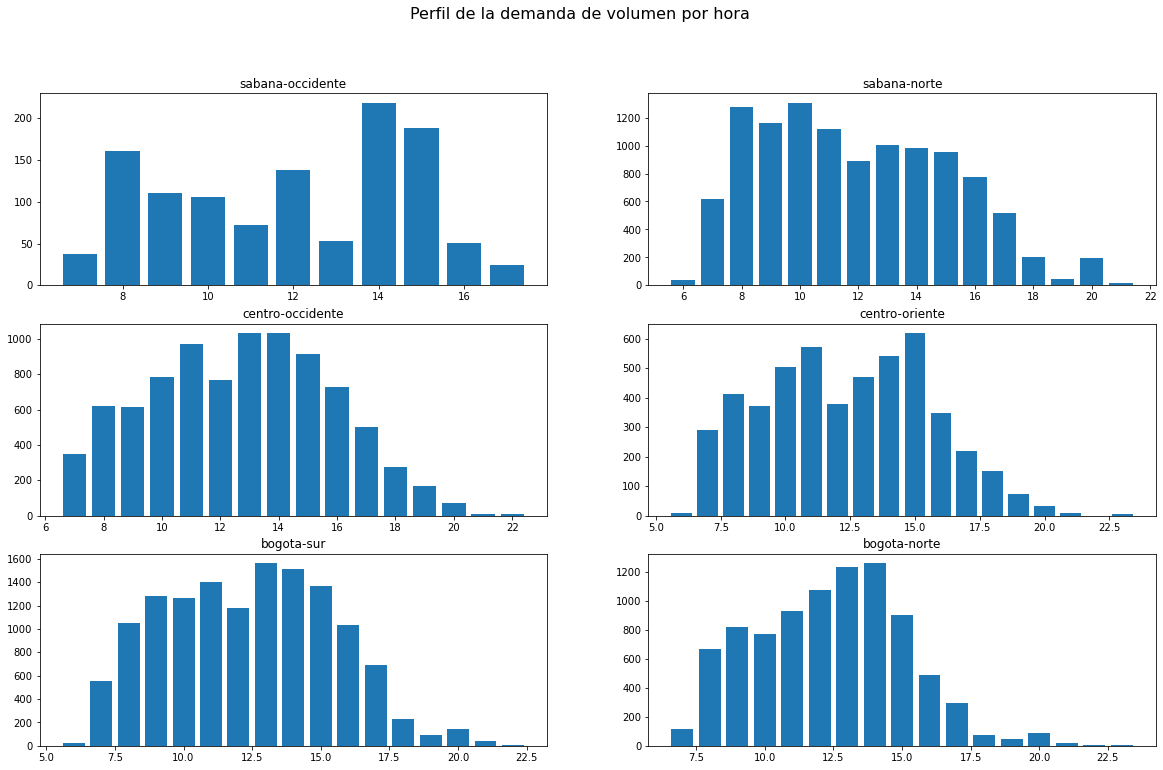

In [13]:
fig, ax=plt.subplots(3,2, figsize=(20,12))
grafico1 = ax[0,0].bar(df_hist_group[(df_hist_group['year_month']=='2022-02') & (df_hist_group['Zona Comercial']=='sabana-occidente')]['HoraEntregaPartida'], df_hist_group[(df_hist_group['year_month']=='2022-02') & (df_hist_group['Zona Comercial']=='sabana-occidente')]['VolPartida'] )
ax[0,0].set_title('sabana-occidente')

grafico1 = ax[0,1].bar(df_hist_group[(df_hist_group['year_month']=='2022-02') & (df_hist_group['Zona Comercial']=='sabana-norte')]['HoraEntregaPartida'], df_hist_group[(df_hist_group['year_month']=='2022-02') & (df_hist_group['Zona Comercial']=='sabana-norte')]['VolPartida'] )
ax[0,1].set_title('sabana-norte')

grafico1 = ax[1,0].bar(df_hist_group[(df_hist_group['year_month']=='2022-02') & (df_hist_group['Zona Comercial']=='centro-occidente')]['HoraEntregaPartida'], df_hist_group[(df_hist_group['year_month']=='2022-02') & (df_hist_group['Zona Comercial']=='centro-occidente')]['VolPartida'] )
ax[1,0].set_title('centro-occidente')

grafico1 = ax[1,1].bar(df_hist_group[(df_hist_group['year_month']=='2022-02') & (df_hist_group['Zona Comercial']=='centro-oriente')]['HoraEntregaPartida'], df_hist_group[(df_hist_group['year_month']=='2022-02') & (df_hist_group['Zona Comercial']=='centro-oriente')]['VolPartida'] )
ax[1,1].set_title('centro-oriente')

grafico1 = ax[2,1].bar(df_hist_group[(df_hist_group['year_month']=='2022-02') & (df_hist_group['Zona Comercial']=='bogota-norte')]['HoraEntregaPartida'], df_hist_group[(df_hist_group['year_month']=='2022-02') & (df_hist_group['Zona Comercial']=='bogota-norte')]['VolPartida'] )
ax[2,1].set_title('bogota-norte')

grafico1 = ax[2,0].bar(df_hist_group[(df_hist_group['year_month']=='2022-02') & (df_hist_group['Zona Comercial']=='bogota-sur')]['HoraEntregaPartida'], df_hist_group[(df_hist_group['year_month']=='2022-02') & (df_hist_group['Zona Comercial']=='bogota-sur')]['VolPartida'] )
ax[2,0].set_title('bogota-sur')

fig.suptitle('Perfil de la demanda de volumen por hora', fontsize=16)
plt.show()

In [38]:
writer = pd.ExcelWriter("../datos/volumen_hora" + pd.to_datetime("now").strftime("%Y-%m-%d-%H-%M-%S")  + ".xlsx", engine='xlsxwriter')       
df_hist_group.to_excel( writer, sheet_name="Base" )
writer.save()

<h2>Volumen(m3) por hora</h2> 

In [5]:
# m3 que puede fabricar una planta por hora
df_m3_hora = df.groupby(['year_month','Planta','Centro']).agg({'VolPartida':sum, 'TiempoCargue':sum}).reset_index()
df_m3_hora['m3hora'] = (df_m3_hora['VolPartida'] / df_m3_hora['TiempoCargue']) * 60.0

#m3 que ha fabricado una planta en cada hora de cada dia
df_m3_fab_hora = df.groupby(['year_month','Planta','Centro', 'FechaEntrega', 'HoraFabricacion']).agg({'VolPartida':sum}).reset_index()

# se calcula que tanto ha fabricado la planta con respecto a su tasa de m3 por hora
df_max_produccion = pd.merge(df_m3_fab_hora, df_m3_hora[['year_month', 'Centro','m3hora']], how='inner', on = ['year_month','Centro'])
df_max_produccion['nivel_produccion'] = df_max_produccion['VolPartida']/df_max_produccion['m3hora']

In [41]:
df_max_produccion

,year_month,Planta,Centro,FechaEntrega,HoraFabricacion,VolPartida,m3hora,nivel_produccion
0,2021-01,CO-PLANTA 240,F001,2021-01-04,10,24.50,56.936359,0.430305
1,2021-01,CO-PLANTA 240,F001,2021-01-04,11,33.25,56.936359,0.583985
2,2021-01,CO-PLANTA 240,F001,2021-01-04,12,49.00,56.936359,0.860610
3,2021-01,CO-PLANTA 240,F001,2021-01-04,13,42.00,56.936359,0.737666
4,2021-01,CO-PLANTA 240,F001,2021-01-04,14,42.50,56.936359,0.746447
...,...,...,...,...,...,...,...,...
23015,2021-04,CO-PLANTA VISTA HERMOSA,F086,2021-04-26,16,4.00,38.944378,0.102711
23016,2021-04,CO-PLANTA VISTA HERMOSA,F086,2021-04-26,6,3.00,38.944378,0.077033
23017,2021-04,CO-PLANTA VISTA HERMOSA,F086,2021-04-26,7,3.00,38.944378,0.077033
23018,2021-04,CO-PLANTA VISTA HERMOSA,F086,2021-04-26,8,3.25,38.944378,0.083452


In [33]:
writer = pd.ExcelWriter("../datos/nivel_produccion" + pd.to_datetime("now").strftime("%Y-%m-%d-%H-%M-%S")  + ".xlsx", engine='xlsxwriter')       
df_max_produccion.to_excel( writer, sheet_name="produccion" )
writer.save()

In [43]:
dff = df_max_produccion[df_max_produccion['nivel_produccion'] >= 0.9]

In [46]:
df_obras_max_produccion = pd.merge(df, dff[['year_month', 'HoraFabricacion', 'Centro','nivel_produccion']], how='left', left_on= ['year_month', 'HoraFabricacion', 'Centro'], right_on=['year_month', 'HoraFabricacion', 'Centro'] )
df_obras_max_produccion = df_obras_max_produccion[df_obras_max_produccion['nivel_produccion'] > 0]
df_obras_max_produccion = df_obras_max_produccion.groupby(['year_month','Obra', 'NombreObra', 'Cliente', 'NombreCliente', 'Centro', 'Planta']).agg({'nivel_produccion':'count'}).reset_index()
df_obras_max_produccion

,year_month,Obra,NombreObra,Cliente,NombreCliente,Centro,Planta,nivel_produccion
0,2021-01,65683432,MEDITERRANEO ALEJANDRIA,50118948,CONSTRUCTORA BOLIVAR S A,F080,CO-PLANTA CALLE 170,4
1,2021-01,65784521,PLANTA COMPRE COLOMBIA,50393899,COMERCIALIZACION Y PREFABRICACION,F011,CO-PLANTA MEDELLIN,18
2,2021-01,66273751,BLUE SKY,50706684,ADVANCE CONSTRUCTORA S.A.S,F080,CO-PLANTA CALLE 170,3
3,2021-01,66372297,ACQUA,50119577,CONSTRUCTORA CAPITAL BOGOTA SAS,F001,CO-PLANTA 240,137
4,2021-01,66372297,ACQUA,50119577,CONSTRUCTORA CAPITAL BOGOTA SAS,F007,CO-PLANTA TOCANCIPA,31
...,...,...,...,...,...,...,...,...
3045,2021-04,66958088,ATS REFA 1352912 TECNOGAS PARQUE,50971836,CONSTRUCCIONES ACERO SAS,F003,CO-PLANTA BOSA,1
3046,2021-04,F009,PLANTA CALI,7460,"CEMEX COLOMBIA,S.A.",F009,CO-PLANTA CALI,2
3047,2021-04,FB84,PTAR CANOAS,7460,"CEMEX COLOMBIA,S.A.",FB84,CO-PLANTA Canoas,2
3048,2021-04,FK52,CO ESTACION AGUABANCA MIO CALI,7460,"CEMEX COLOMBIA,S.A.",F009,CO-PLANTA CALI,24


In [ ]:
writer = pd.ExcelWriter("../datos/nivel_produccion" + pd.to_datetime("now").strftime("%Y-%m-%d-%H-%M-%S")  + ".xlsx", engine='xlsxwriter')       
df_obras_max_produccion.to_excel( writer, sheet_name="produccion" )
writer.save()

<h1>Costo por m3</h1>

In [ ]:
df_consuticket = querySQL( "SELECT * FROM AT52_InventariosMateriales WHERE fechainicio > ?" , ('2021-01-01') )
df_consuticket = df_consuticket.fillna(value=np.nan)

In [7]:
df_consuticket

,ID,FechaInicio,FechaFin,HoraInicio,HoraFin,OrdenProduccion,Entrega,Centro,TipoMaterial,UnidadMedida,Estatus,CantidadReal,Material,TextoBreveMaterial
0,1431202,2021-02-01,2021-02-01,1900-01-01 13:32:12,1900-01-01 14:31:20,700038627478,189694139,F080,ADI,ML,Normal,3799.915,10157439,ISOFLOW 9001
1,1431203,2021-02-01,2021-02-01,1900-01-01 13:32:12,1900-01-01 14:31:20,700038627478,189694139,F080,CEM,KG,Normal,113.000,1400003529,"ADI. CONC. ESP.,CENIZA VOLANTE,GRA"
2,1431204,2021-02-01,2021-02-01,1900-01-01 13:32:12,1900-01-01 14:31:20,700038627478,189694139,F080,AGU,L,Normal,570.000,91,Agua
3,1431205,2021-02-01,2021-02-01,1900-01-01 13:32:12,1900-01-01 14:31:20,700038627478,189694139,F080,ARE,KG,Normal,4471.000,10000027,ARENA ANDESITA No. 4
4,1431206,2021-02-01,2021-02-01,1900-01-01 13:32:12,1900-01-01 14:31:20,700038627478,189694139,F080,CEM,KG,Normal,815.000,10002233,CEM ART NTC121 2014 CEMEX GRANEL.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438499,1477525,2021-02-10,2021-02-10,1900-01-01 07:12:32,1900-01-01 08:11:09,700038667393,190107009,F030,CEM,KG,Normal,2338.000,10002233,CEM ART NTC121 2014 CEMEX GRANEL.
438500,1477526,2021-02-10,2021-02-10,1900-01-01 07:12:32,1900-01-01 08:11:09,700038667393,190107009,F030,GRA,KG,Normal,7535.000,10002236,"GRAVA,ALUVIAL,60-80 (3/4-1"" ),65 SIO2,HU"
438501,1477527,2021-02-10,2021-02-10,1900-01-01 07:12:32,1900-01-01 08:11:09,700038667393,190107009,F030,ADI,ML,Normal,11889.520,10037732,ISOPLAST 157
438502,1477528,2021-02-10,2021-02-10,1900-01-01 07:12:32,1900-01-01 08:11:09,700038667393,190107009,F030,ADI,ML,Normal,11977.240,10157439,ISOFLOW 9001


In [8]:
df_inventarios = querySQL( "SELECT * FROM AT52_InventariosMateriales" , () )
df_inventarios = df_inventarios.fillna(value=np.nan)

In [9]:
df_inventarios

,ID,Material,Centro,TextoBreveMaterial,UltimaModificacion,UnidadMedida,Precio,Moneda,HoraConsulta
0,1,1500000924,F001,"ADI DIESEL,HIDRO,HIDROBLUE,1000L",2019-03-05,EA,1000000,COP,2021-05-10 00:00:00
1,2,10002235,F001,"CEMENTO,BLANCO,ASTM C150,CEMENTOS DEL NA",2020-11-26,TN,656334,COP,2021-05-10 00:00:00
2,3,1500000921,F001,"ADI DIESEL,HIDRO,HIDROBLUE,GRANEL",2019-04-09,EA,500000,COP,2021-05-10 00:00:00
3,4,1500000923,F001,"ADI DIESEL,HIDRO,HIDROBLUE,200L",2019-03-05,EA,500000,COP,2021-05-10 00:00:00
4,5,10002233,F001,CEM ART NTC121 2014 CEMEX GRANEL.,2021-05-05,TN,341449,COP,2021-05-10 00:00:00
...,...,...,...,...,...,...,...,...,...
7073,7074,10037632,FB25,ISOXEL 436,2021-05-01,L,1437,COP,2021-05-11 13:22:52
7074,7075,1400003530,FB25,"ADI. CONC. ESP.,MBT MICRO AIR 920,GRANEL",2021-04-30,L,1146,COP,2021-05-11 13:22:52
7075,7076,1400003536,FB25,"ADI. CONC. ESP.,MBT POZZOLITH 122HE,GRAN",2021-04-30,L,1133,COP,2021-05-11 13:22:52
7076,7077,10037732,FB25,ISOPLAST 157,2021-05-01,L,1115,COP,2021-05-11 13:22:52


In [11]:
df_costos = pd.merge(df_consuticket[['Entrega', 'Material', 'Centro']], df_inventarios, how = 'left', on=['Material', 'Centro'])

In [12]:
df_costos

,ID_x,FechaInicio,FechaFin,HoraInicio,HoraFin,OrdenProduccion,Entrega,Centro,TipoMaterial,UnidadMedida_x,...,CantidadReal,Material,TextoBreveMaterial_x,ID_y,TextoBreveMaterial_y,UltimaModificacion,UnidadMedida_y,Precio,Moneda,HoraConsulta
0,1431202,2021-02-01,2021-02-01,1900-01-01 13:32:12,1900-01-01 14:31:20,700038627478,189694139,F080,ADI,ML,...,3799.915,10157439,ISOFLOW 9001,NaN,NaN,NaT,NaN,NaN,NaN,NaT
1,1431203,2021-02-01,2021-02-01,1900-01-01 13:32:12,1900-01-01 14:31:20,700038627478,189694139,F080,CEM,KG,...,113.000,1400003529,"ADI. CONC. ESP.,CENIZA VOLANTE,GRA",NaN,NaN,NaT,NaN,NaN,NaN,NaT
2,1431204,2021-02-01,2021-02-01,1900-01-01 13:32:12,1900-01-01 14:31:20,700038627478,189694139,F080,AGU,L,...,570.000,91,Agua,NaN,NaN,NaT,NaN,NaN,NaN,NaT
3,1431205,2021-02-01,2021-02-01,1900-01-01 13:32:12,1900-01-01 14:31:20,700038627478,189694139,F080,ARE,KG,...,4471.000,10000027,ARENA ANDESITA No. 4,NaN,NaN,NaT,NaN,NaN,NaN,NaT
4,1431206,2021-02-01,2021-02-01,1900-01-01 13:32:12,1900-01-01 14:31:20,700038627478,189694139,F080,CEM,KG,...,815.000,10002233,CEM ART NTC121 2014 CEMEX GRANEL.,NaN,NaN,NaT,NaN,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438499,1477525,2021-02-10,2021-02-10,1900-01-01 07:12:32,1900-01-01 08:11:09,700038667393,190107009,F030,CEM,KG,...,2338.000,10002233,CEM ART NTC121 2014 CEMEX GRANEL.,NaN,NaN,NaT,NaN,NaN,NaN,NaT
438500,1477526,2021-02-10,2021-02-10,1900-01-01 07:12:32,1900-01-01 08:11:09,700038667393,190107009,F030,GRA,KG,...,7535.000,10002236,"GRAVA,ALUVIAL,60-80 (3/4-1"" ),65 SIO2,HU",NaN,NaN,NaT,NaN,NaN,NaN,NaT
438501,1477527,2021-02-10,2021-02-10,1900-01-01 07:12:32,1900-01-01 08:11:09,700038667393,190107009,F030,ADI,ML,...,11889.520,10037732,ISOPLAST 157,NaN,NaN,NaT,NaN,NaN,NaN,NaT
438502,1477528,2021-02-10,2021-02-10,1900-01-01 07:12:32,1900-01-01 08:11:09,700038667393,190107009,F030,ADI,ML,...,11977.240,10157439,ISOFLOW 9001,NaN,NaN,NaT,NaN,NaN,NaN,NaT
